In [15]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from astropy.io import fits, ascii
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, MinMaxInterval, ZScaleInterval, LogStretch
from astropy.visualization.wcsaxes import add_scalebar
import astropy.units as u
from astropy.table import Table

In [47]:
field = 'CEERS'
filter = 'f200w'
hdu       = fits.open(glob.glob(f"/home/aurelien/DAWN/DJA_SE++/image/{field}/cutout/*{filter}*sci*.fits")[0], memmap=True)[0]
model_hdu = fits.open(glob.glob(f"/home/aurelien/DAWN/DJA_SE++/sepp/{field}/checkimages/model*{filter}*.fits")[0], memmap=True)[0]
resid_hdu = fits.open(glob.glob(f"/home/aurelien/DAWN/DJA_SE++/sepp/{field}/checkimages/resid*{filter}*.fits")[0], memmap=True)[0]

In [48]:
cat = Table(fits.open(glob.glob(f"/home/aurelien/DAWN/DJA_SE++/sepp/{field}/*sepp_cat.fits")[0])[1].data)

In [49]:
print(cat.keys())

['pixel_centroid_x', 'pixel_centroid_y', 'world_centroid_alpha', 'world_centroid_delta', 'source_id', 'detection_id', 'group_id', 'group_stamp_top', 'group_stamp_left', 'group_stamp_width', 'group_stamp_height', 'source_flags', 'n_detected_pixels', 'n_core_pixel', 'APER_flux', 'APER_flux_err', 'APER_mag', 'APER_mag_err', 'APER_flags', 'auto_flux', 'auto_flux_err', 'auto_mag', 'auto_mag_err', 'auto_flags', 'flux_radius', 'snrratio', 'ellipse_a', 'ellipse_b', 'ellipse_theta', 'ellipse_cxx', 'ellipse_cyy', 'ellipse_cxy', 'area', 'elongation', 'ellipticity', 'fmf_reduced_chi_2', 'fmf_iterations', 'fmf_stop_reason', 'fmf_duration', 'fmf_flags', 'fmf_chi2_per_meta', 'fmf_iterations_per_meta', 'fmf_meta_iterations', 'X_MODEL', 'X_MODEL_err', 'Y_MODEL', 'Y_MODEL_err', 'RA_MODEL', 'RA_MODEL_err', 'DEC_MODEL', 'DEC_MODEL_err', 'RADIUS', 'RADIUS_err', 'AXRATIO', 'AXRATIO_err', 'ANGLE', 'ANGLE_err', 'E1', 'E1_err', 'E2', 'E2_err', 'SERSIC', 'SERSIC_err', 'X_SERSIC', 'X_SERSIC_err', 'DET-IMG_RADIUS

### Catalog fit

In [50]:
def add_good_scalebar(ax, wcs, color='white', fraction=0.25):
    width = abs(wcs.pixel_scale_matrix[0,0]*wcs.pixel_shape[0])*u.degree
    good_values = [0.5*u.arcsec, 1*u.arcsec, 2*u.arcsec, 3*u.arcsec, 5*u.arcsec, 10*u.arcsec, 20*u.arcsec,
                   0.5*u.arcmin, 1*u.arcmin, 2*u.arcmin, 3*u.arcmin, 5*u.arcmin, 10*u.arcmin, 20*u.arcmin,
                   0.5*u.degree, 1*u.degree, 2*u.degree, 5*u.degree, 10*u.degree]
    dist = np.array([(fraction*width-val).value for val in good_values])
    dist[dist<0] = np.inf
    size = good_values[np.argmin(dist)]
    add_scalebar(ax, size, label=f"{size:latex}", color=color, fontproperties=FontProperties(size='x-large'), label_top=True, pad=0.1)

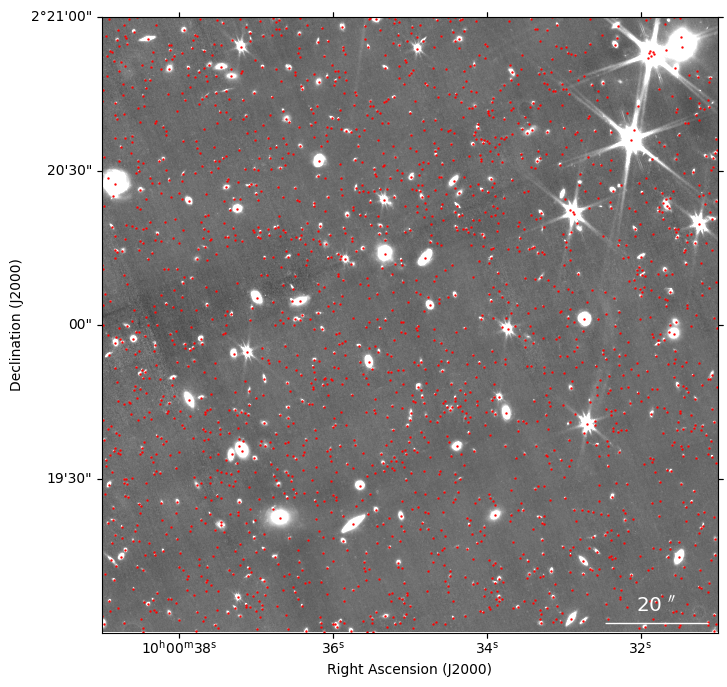

In [51]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection':WCS(hdu.header)})
norm = ImageNormalize(hdu.data, interval=ZScaleInterval())
ax.imshow(hdu.data, cmap='gray', origin='lower', norm=norm)
ax.scatter(cat['world_centroid_alpha'], cat['world_centroid_delta'], transform=ax.get_transform('world'), c='r', s=0.5)
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')
add_good_scalebar(ax, WCS(hdu.header))
plt.show()

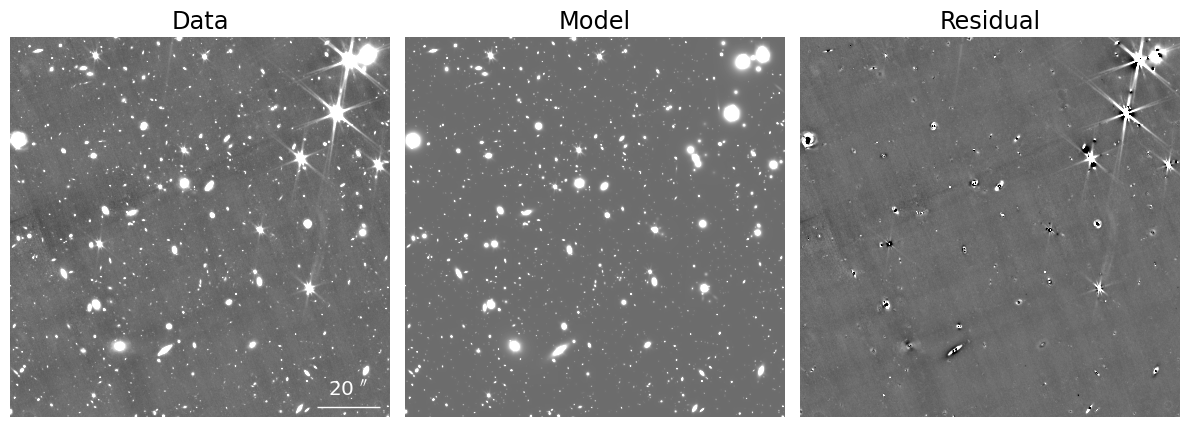

In [52]:
fig = plt.figure(figsize=(12,8))
#Plots data
wcs = WCS(hdu.header)
ax = fig.add_subplot(1,3,1, projection=wcs)
norm = ImageNormalize(hdu.data, interval=ZScaleInterval())
ax.imshow(hdu.data, cmap='gray', origin='lower', norm=norm)
add_good_scalebar(ax, wcs)
ax.set_axis_off()
ax.set_title("Data", size='xx-large')
# Plots model
ax_model = fig.add_subplot(1,3,2, projection=wcs)
ax_model.imshow(model_hdu.data, cmap='gray', origin='lower', norm=norm)
ax_model.set_axis_off()
ax_model.set_title("Model", size='xx-large')
# Plots residual
ax_resid = fig.add_subplot(1,3,3, projection=wcs)
ax_resid.imshow(resid_hdu.data, cmap='gray', origin='lower', norm=norm)
ax_resid.set_axis_off()
ax_resid.set_title("Residual", size='xx-large')

fig.tight_layout()
plt.show()

### Zoom and image-model displays

In [12]:
def show_source(id, cat, field):
    target = SkyCoord(cat['world_centroid_alpha'][id], cat['world_centroid_delta'][id], frame='icrs', unit='deg')
    size = u.Quantity((3.3,3.3), u.arcsec)

    def add_good_scalebar(ax, wcs, color='white', fraction=0.25):
        width = abs(wcs.pixel_scale_matrix[0,0]*wcs.pixel_shape[0])*u.degree
        good_values = [0.5*u.arcsec, 1*u.arcsec, 2*u.arcsec, 3*u.arcsec, 5*u.arcsec, 10*u.arcsec, 20*u.arcsec,
                    0.5*u.arcmin, 1*u.arcmin, 2*u.arcmin, 3*u.arcmin, 5*u.arcmin, 10*u.arcmin, 20*u.arcmin,
                    0.5*u.degree, 1*u.degree, 2*u.degree, 5*u.degree, 10*u.degree]
        dist = np.array([(fraction*width-val).value for val in good_values])
        dist[dist<0] = np.inf
        size = good_values[np.argmin(dist)]
        add_scalebar(ax, size, label=f"{size:latex}", color=color, fontproperties=FontProperties(size='x-large'), label_top=True, pad=0.1)

    fig = plt.figure(figsize=(2*len(filter_list)+1,2*3+0.5))
    for i, filter in enumerate(filter_list):
        # Loads images
        hdu       = fits.open(glob.glob(f"/home/aurelien/DAWN/DJA_SE++/image/{field}/cutout/*{filter}*sci*.fits")[0], memmap=True)[0]
        model_hdu = fits.open(glob.glob(f"/home/aurelien/DAWN/DJA_SE++/sepp/{field}-old/checkimages/model*{filter}*.fits")[0], memmap=True)[0]
        resid_hdu = fits.open(glob.glob(f"/home/aurelien/DAWN/DJA_SE++/sepp/{field}-old/checkimages/resid*{filter}*.fits")[0], memmap=True)[0]
        wcs = WCS(hdu.header)
        # Cutouts in images
        cutout       = Cutout2D(hdu.data,       position=target, size=size, wcs=wcs)
        model_cutout = Cutout2D(model_hdu.data, position=target, size=size, wcs=wcs)
        resid_cutout = Cutout2D(resid_hdu.data, position=target, size=size, wcs=wcs)
        #Plots data
        ax = fig.add_subplot(3,len(filter_list),i+1, projection=cutout.wcs)
        norm = ImageNormalize(cutout.data, interval=ZScaleInterval())
        # norm = ImageNormalize(cutout.data, interval=MinMaxInterval(), stretch=LogStretch())
        ax.imshow(cutout.data, cmap='gray', origin='lower', norm=norm)
        add_good_scalebar(ax, cutout.wcs, fraction=1.0)
        ax.set_title(filter.upper(), fontsize=24)
        ax.set_axis_off()
        # Plots model
        ax_model = fig.add_subplot(3,len(filter_list),i+len(filter_list)+1, projection=cutout.wcs)
        ax_model.imshow(model_cutout.data, cmap='gray', origin='lower', norm=norm)
        ax_model.set_axis_off()
        # Plots residual
        ax_resid = fig.add_subplot(3,len(filter_list),i+2*len(filter_list)+1, projection=cutout.wcs)
        ax_resid.imshow(resid_cutout.data, cmap='gray', origin='lower', norm=norm)
        ax_resid.set_axis_off()
    plt.figtext(1.0, 0.79, "Data", figure=fig, va='center', ha='left', rotation='vertical', fontsize='xx-large')
    plt.figtext(1.0, 0.48, "Model", figure=fig, va='center', ha='left',rotation='vertical', fontsize='xx-large')
    plt.figtext(1.0, 0.17, "Residual", figure=fig, va='center', ha='left',rotation='vertical', fontsize='xx-large')
    plt.figtext(0.0, 0.48, f"Source #{id}", figure=fig, va='center', ha='right', rotation='vertical', fontsize=24)
    fig.tight_layout()
    plt.show()

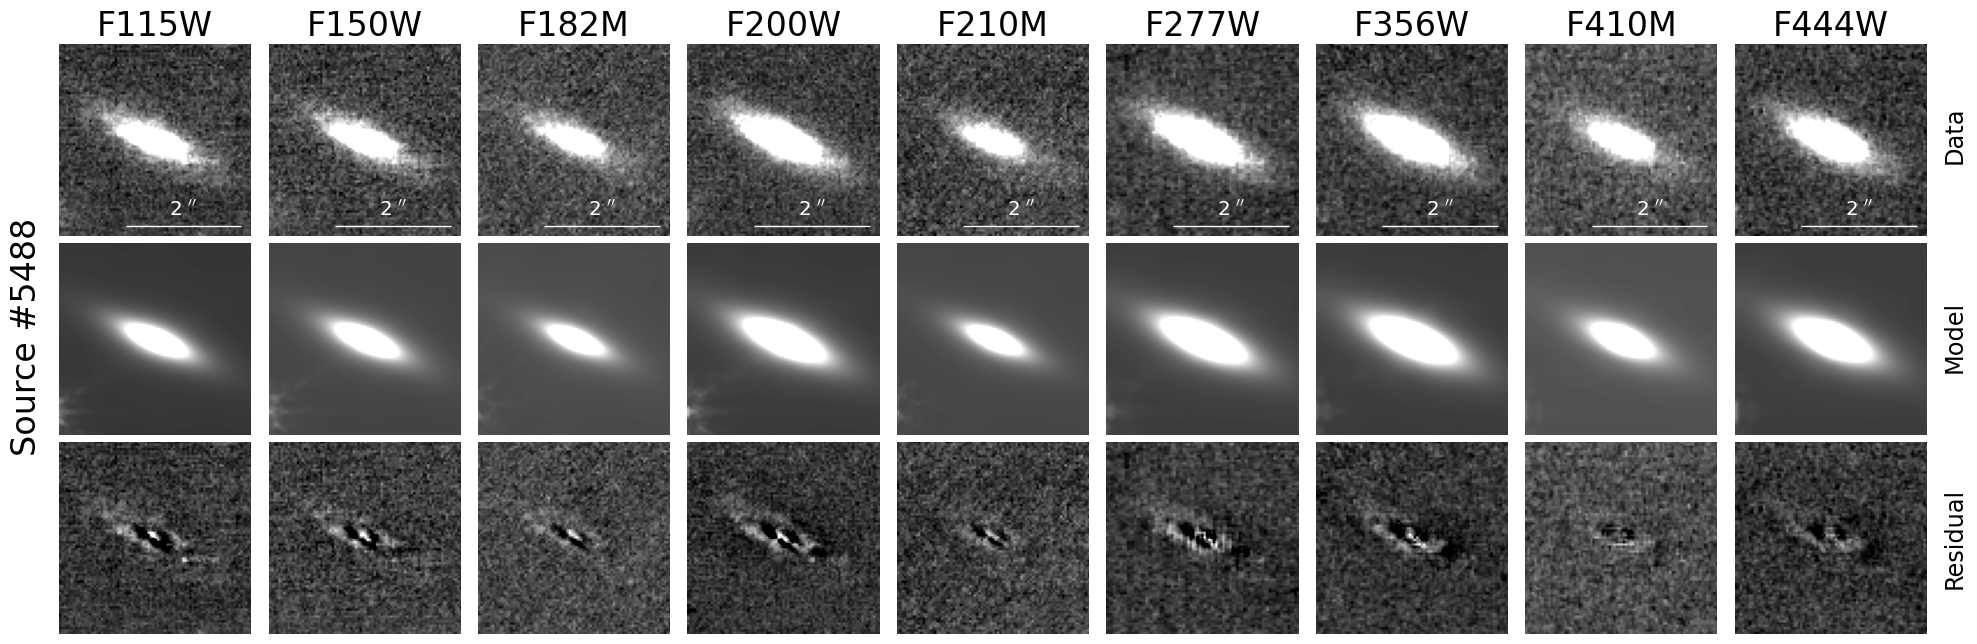

In [46]:
# filter_list = ['f090w', 'f115w', 'f150w', 'f182m', 'f200w', 'f210m', 'f277w', 'f335m', 'f356w', 'f410m', 'f444w']
# filter_list = ['f090w', 'f115w', 'f150w', 'f182m', 'f200w', 'f210m', 'f277w', 'f335m', 'f356w', 'f410m', 'f444w']
filter_list = [key.split("_")[-1].lower() for key in cat.keys() if (('MAG' in key) and ('err' not in key))]

id = 5488
show_source(id, cat, field)

### Photometric spectrum

In [22]:
def plot_filters(ax, filter_list, scale=1, names=True, throughput_folder="/home/aurelien/DAWN/DJA_SE++/JWST-doc/NIRCam_Filters-Throughput"):
    """
    Plots filters throughput on ax
    Sources : https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-filters
    """
    color_dict = {'F090W':'#0000E3', 
                  'F115W':'#1020FF',
                  'F150W':'#0162FF',
                  'F182M':'#00B1FF',
                  'F200W':'#04D1FF',
                  'F210M':'#02E8F4',
                  'F277W':'#87FF7F',
                  'F335M':'#EBFF0C',
                  'F356W':'#FFD807',
                  'F410M':'#FF6D03',
                  'F444W':'#FF330C',}
    for filter in filter_list:
        table = ascii.read(f"{throughput_folder}/{filter.upper()}_mean_system_throughput.txt")
        color = color_dict[filter.upper()] if filter.upper() in color_dict else '#000000'
        max_val = scale if 'w' in filter else scale/2
        ax.plot(table['Microns'], max_val*table['Throughput']/table['Throughput'].max(), color=color)
        ax.fill_between(table['Microns'], max_val*table['Throughput']/table['Throughput'].max(), alpha=0.4, color=color)
        if names: ax.text(np.average(table['Microns'], weights=table['Throughput']), 0.55*max_val, filter.upper(), ha='center', va='center', c='k', size='x-small')

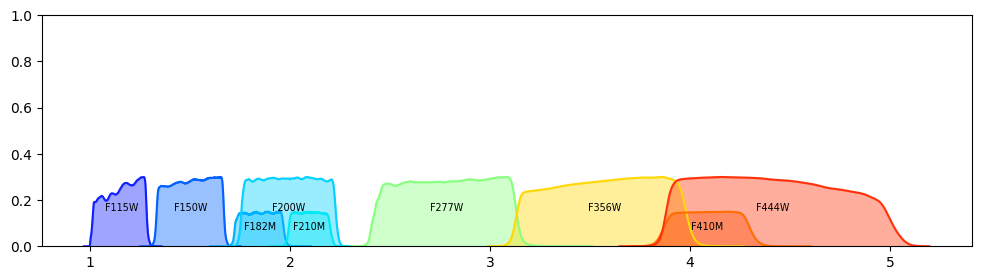

In [23]:
fig, ax = plt.subplots(figsize=(12,3))
plot_filters(ax, filter_list, scale=0.3, names=True)
ax.set_ylim(0,1)
plt.show()

In [42]:
def plot_photometric_spectrum(id, cat, mag=False, custom_ax=None, title=None):
    """
    Plots photometric spectrum of cat[id] in flux or mag depending of `mag` (default, flux).
    """
    filters_waveband = {'F090W': {'pivot': 0.901, 'band': 0.194},
                        'F115W': {'pivot': 1.154, 'band': 0.225},
                        'F150W': {'pivot': 1.501, 'band': 0.318},
                        'F182M': {'pivot': 1.845, 'band': 0.238},
                        'F200W': {'pivot': 1.990, 'band': 0.461},
                        'F210M': {'pivot': 2.093, 'band': 0.205},
                        'F277W': {'pivot': 2.786, 'band': 0.672},
                        'F300M': {'pivot': 2.996, 'band': 0.318},
                        'F335M': {'pivot': 3.365, 'band': 0.347},
                        'F356W': {'pivot': 3.563, 'band': 0.787},
                        'F410M': {'pivot': 4.092, 'band': 0.436},
                        'F444W': {'pivot': 4.421, 'band': 1.024},}

    ax = plt.subplots(figsize=(12,3))[1] if custom_ax is None else custom_ax
    flux_target = [10*cat[id-1][f"FLUX_MODEL_{filter.upper()}"] for filter in filter_list]
    flux_err_target = [10*cat[id-1][f"FLUX_MODEL_{filter.upper()}_err"] for filter in filter_list]
    mag_target = [cat[id-1][f"MAG_MODEL_{filter.upper()}"] for filter in filter_list]
    mag_err_target = [cat[id-1][f"MAG_MODEL_{filter.upper()}_err"] for filter in filter_list]

    plot_filters(ax, filter_list, (max(mag_target) if mag else max(flux_target))/5)
    if mag:
        ax.errorbar([filters_waveband[filter.upper()]['pivot'] for filter in filter_list], mag_target, 
                    xerr=np.array([filters_waveband[filter.upper()]['band'] for filter in filter_list])/2, yerr=mag_err_target, 
                    fmt='o', ms=3, c='k', capsize=3, capthick=1)
    else:
        ax.errorbar([filters_waveband[filter.upper()]['pivot'] for filter in filter_list], flux_target, 
                    xerr=np.array([filters_waveband[filter.upper()]['band'] for filter in filter_list])/2, yerr=flux_err_target, 
                    fmt='o', ms=3, c='k', capsize=3, capthick=1)
    ax.set_xlabel("Wavelength (µm)")
    if mag:
        ax.set_ylabel("AB Mag")
    else:
        ax.set_ylabel(r"$F_{\nu}$ (nJy)")
    ax.set_title(title)
    if custom_ax is None: plt.show()

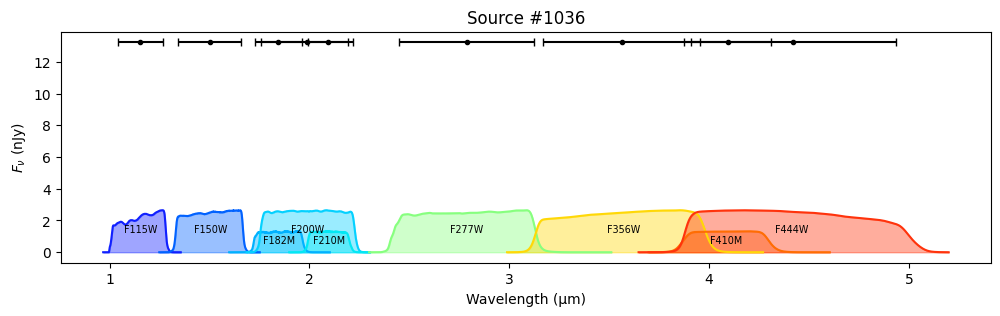

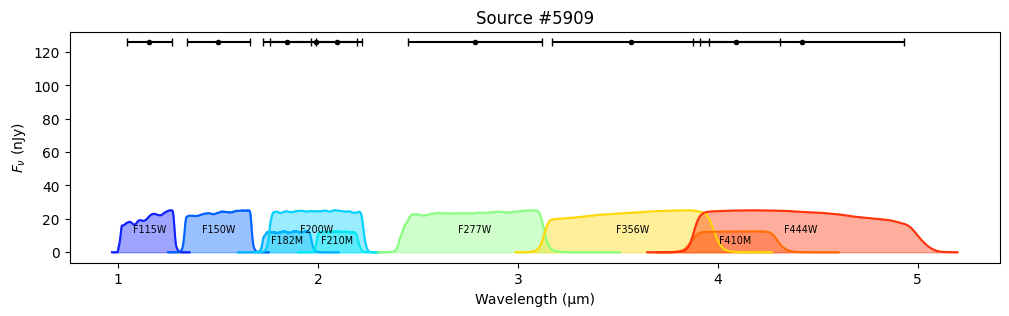

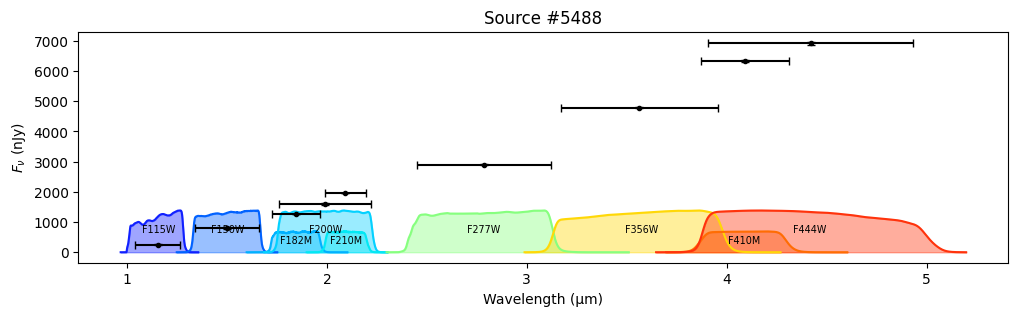

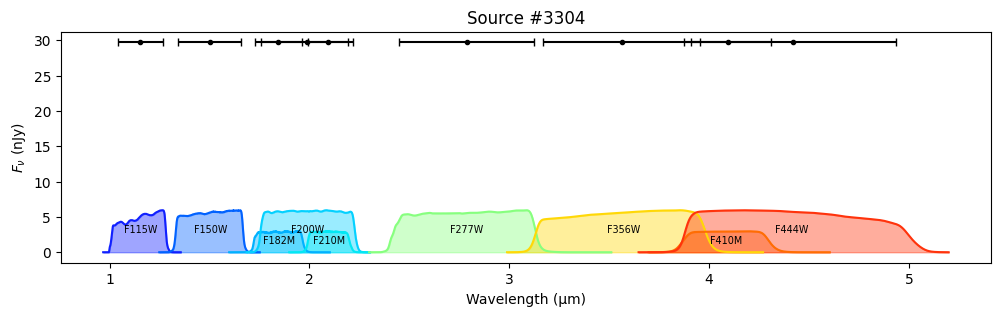

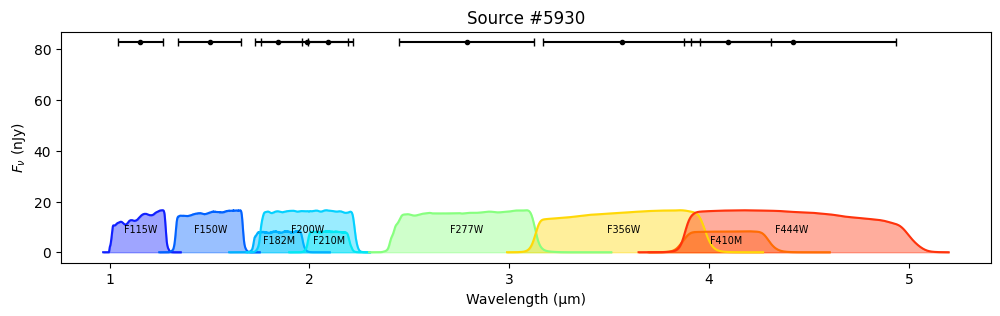

In [45]:
# cat_points = SkyCoord(cat['world_centroid_alpha'], cat['world_centroid_delta'], unit='deg', frame='icrs', equinox='J2000')
# sep = target.separation(cat_points)
# idx = np.argmin(sep)

for id in np.random.randint(0, len(cat), 5):
    plot_photometric_spectrum(id, cat, mag=False, title=f"Source #{id}")